In [5]:
import networkx
import pandas as pd

In [1]:
!wget https://snap.stanford.edu/data/twitch.zip

--2021-11-09 18:47:37--  https://snap.stanford.edu/data/twitch.zip
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2842994 (2,7M) [application/zip]
Saving to: ‘twitch.zip’

twitch.zip          100%[===================>]   2,71M   887KB/s    in 3,1s    

2021-11-09 18:47:41 (887 KB/s) - ‘twitch.zip’ saved [2842994/2842994]



In [2]:
!unzip twitch.zip

Archive:  twitch.zip
   creating: twitch/
   creating: twitch/DE/
  inflating: twitch/DE/musae_DE.json  
  inflating: twitch/DE/musae_DE_edges.csv  
  inflating: twitch/DE/musae_DE_target.csv  
   creating: twitch/ENGB/
  inflating: twitch/ENGB/musae_ENGB_edges.csv  
  inflating: twitch/ENGB/musae_ENGB_features.json  
  inflating: twitch/ENGB/musae_ENGB_target.csv  
   creating: twitch/ES/
  inflating: twitch/ES/musae_ES_edges.csv  
  inflating: twitch/ES/musae_ES_features.json  
  inflating: twitch/ES/musae_ES_target.csv  
   creating: twitch/FR/
  inflating: twitch/FR/musae_FR_edges.csv  
  inflating: twitch/FR/musae_FR_features.json  
  inflating: twitch/FR/musae_FR_target.csv  
   creating: twitch/PTBR/
  inflating: twitch/PTBR/musae_PTBR_edges.csv  
  inflating: twitch/PTBR/musae_PTBR_features.json  
  inflating: twitch/PTBR/musae_PTBR_target.csv  
   creating: twitch/RU/
  inflating: twitch/RU/musae_RU_edges.csv  
  inflating: twitch/RU/musae_RU_features.json  
  inflating: twitc

In [6]:
GRAPH_DIR = "twitch/DE"

In [10]:
edges = pd.read_csv(GRAPH_DIR + "/musae_DE_edges.csv")

In [16]:
edges

,from,to
0,0,9206
1,0,7787
2,0,2145
3,0,2684
4,0,7275
...,...,...
153133,2547,2092
153134,9461,2092
153135,9295,7802
153136,7436,9487


In [11]:
nodes = pd.read_csv(GRAPH_DIR + "/musae_DE_target.csv")

In [12]:
nodes

,id,days,mature,views,partner,new_id
0,37905227,2149,True,162078,False,5079
1,63102384,1574,True,1370,False,4281
2,109414094,1034,True,6043,False,992
3,84163849,1319,True,94298,True,9021
4,38240837,2137,True,2323,False,330
...,...,...,...,...,...,...
9493,123101102,895,True,128,False,4572
9494,40627165,2001,False,44,False,6355
9495,50643307,1784,True,2038,False,206
9496,38810779,2114,False,449,False,7695


In [15]:
import networkx as nx

In [18]:
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(edges, source='from', target='to', create_using=Graphtype)

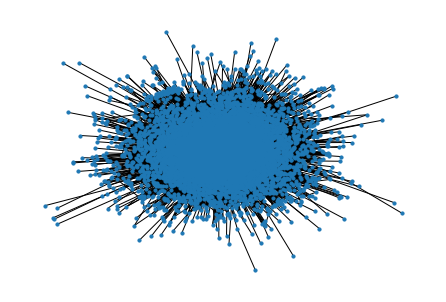

In [22]:
nx.draw(G, node_size=10)  